In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder

## 2値分類  
この章からは主に**分類**について扱っていく。前章までの回帰は連続した値を予測していたのに対し、分類はデータをあらかじめ決めておいたグループのどれにそれが属するかを予測する。この章で扱う2値分類はこのグループが2つのもので、例を挙げると、その人のアンケート結果からその人が男か女かを予測したり、受信したメールが迷惑メールかそうでないかを予測することがあげられる。

### ラベル推定式
$d$次元の特徴ベクトルの事例$\boldsymbol{x}$が与えられたとき、線形モデルのパラメータ$\boldsymbol{w}$との内積を計算し、その正負でラベル$\hat{y}$を予測する。
線形2値分類のラベル推定式は以下のようになる。
$$
\hat{y} = \left\{
    \begin{array}{l}
    1 \qquad (\boldsymbol{x}^\top\boldsymbol{w}>0) \\
    0 \qquad (\boldsymbol{x}^\top\boldsymbol{w}\leqq0)
    \end{array}
\right .
$$


### ロジスティック回帰
ここからはパラメータ$\boldsymbol{w}$を推定していく。ここではロジスティック回帰により線形2値分類を実現していく（回帰とあるが分類に用いられるものである）。このモデルは事例$\boldsymbol{x}$に対するラベル$\hat{y}$の条件付確率$p(y\lvert \boldsymbol{x})$を以下で求める。
$$
p(\hat{y}=1 \lvert \boldsymbol{x}) = \sigma(\boldsymbol{x}^\top\boldsymbol{w}) = \frac{1}{1 + e^{(-\boldsymbol{x}^\top\boldsymbol{w})}}\\
p(\hat{y}=0 \lvert \boldsymbol{x}) = 1 - p(\hat{y}=1 \lvert \boldsymbol{x}) = \sigma(-\boldsymbol{x}\boldsymbol{w}) 
$$
また$\sigma$はシグモイド関数と呼ばれる以下のような関数である。
$$
\sigma(x) = \frac{1}{1 + e^x}
$$
形状は以下のようになる。

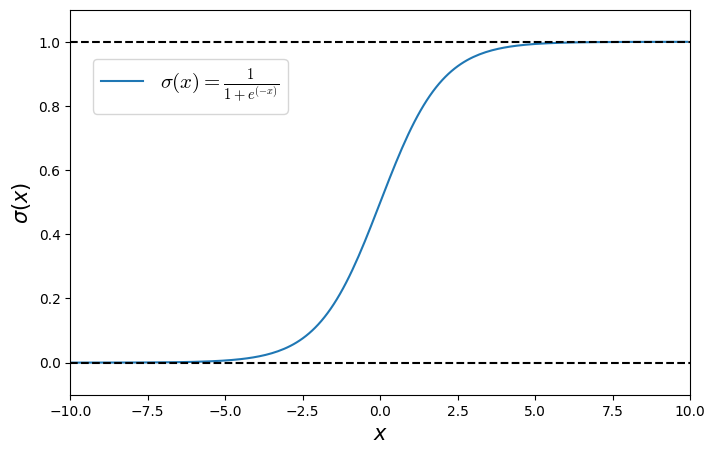

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.arange(-10, 10, 0.1)
y = sigmoid(x)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'

ax.plot(x, y)
ax.hlines(1.0, -10, 10, colors='black', linestyles='dashed')
ax.hlines(0, -10, 10, colors='black', linestyles='dashed')
ax.set_xlim(-10, 10)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel(r'$x$', fontsize=15)
ax.set_ylabel(r'$\sigma(x)$', fontsize=15)
ax.legend([r'$\sigma(x) = \frac{1}{1 + e^{(-x)}}$'], fontsize=15, loc='upper left', bbox_to_anchor=(0.02, 0.9))
plt.show()

上図でもわかるようにシグモイド関数は以下のような性質を持つ。
$$
\left\{
    \begin{array}{l}
    \displaystyle \lim_{x \to \infty} \sigma(x) = 1 \\
    \displaystyle \lim_{x \to -\infty} \sigma(x) = 0 \\
    \end{array}
    \right .
$$
上図では(-10, 10)の範囲でプロットしているが、実際のシグモイド関数の定義域は$(-\infty, \infty)$である。したがってシグモイド関数は入力を0~1の確率値に変換していることになる。

### 最尤推定
回帰問題では実測値と予測値とのずれを示す指標として残差を使った。しかしこの分類問題においてはこの方法は取れない。なぜなら・・・
そこで代わりに行うのが最尤推定で、最小2乗法が残差を最小化させるのに対し、最尤推定は尤度を最大化させる。尤度とはその確率のもっともらしさで、事例$(\boldsymbol{x}, \hat{y})$に対する尤度$\hat{l}_{\boldsymbol{x},\hat{y}}(\boldsymbol{w})$は以下のようになる。
$$
\hat{l}_{\boldsymbol{x},\hat{y}}(\boldsymbol{w}) = p(\hat{y} = y \lvert \boldsymbol{x}) = \left\{
    \begin{array}{l}
    p(\hat{y} = 1 \lvert \boldsymbol{x}) \quad (y = 1のとき) \\
    p(\hat{y} = 0 \lvert \boldsymbol{x}) \quad (y = 0のとき)
    \end{array}
    \right .
    = p^y(1 - p)^{y - 1}
$$
これを使用することで回帰問題の残差のように学習事例をどのくらい正しく再現できているかを定量的にみることができる。具体的には1に近いほど正しく、0に近いほど間違って再現している。  
またデータ全体に対する尤度$\hat{L}_{D}(\boldsymbol{w})$は
$$
\hat{L}_{D}(\boldsymbol{w}) = \prod^{n}_{i=1}\hat{l}_{\boldsymbol{x}_{i},\hat{y}_{i}}(\boldsymbol{w})
$$
ただし学習データのすべての事例は独立同分布  
したがってこの式がこの分類問題の目的関数であり、これを最大化する$\boldsymbol{w^{*}}$を求めることで、データに合致するモデルパラメータを求めることができる。だが、これは少数の積を繰り返すことになるので、コンピュータで計算を続けていくとじきにアンダーフローを起こす可能性がある。なのでこの尤度の対数をとり、対数尤度を最大化させることを考える。よって最尤推定の目的関数は、
$$
log\hat{L}_{D}(\boldsymbol{w}) = log\prod^{n}_{i=1}\hat{l}_{\boldsymbol{x}_{i},\hat{y}_{i}}(\boldsymbol{w}) = \sum^{N}_{i=1}log\hat{l}_{\boldsymbol{x}_{i},\hat{y}_{i}}(\boldsymbol{w})
$$
また回帰問題では目的関数を最小化させることを考えた。よってこの2値分類でも同様に最小化問題へ帰着させるために上式をマイナス倍する。したがって最尤推定の目的関数$\mathcal{L}^{MLE}_{D}(\boldsymbol{w})$は以下のようになる。
$$
\mathcal{L}_{D}(\boldsymbol{w}) = -log\hat{L}_{D} = -\sum^{N}_{i=1}log\hat{l}_{\boldsymbol{x}_{i},\hat{y}_{i}}(\boldsymbol{w})
$$


### 勾配降下法
目的関数が分かったのでこれまで通り微分値を0としてパラメータを求めていきたいが、この目的関数は凸関数ではなく微分値が0となる解が複数存在するためこの方法は取れない。したがって**勾配降下法**によるパラメータ推定を行う。勾配降下法とは、初期値$\boldsymbol{x^{(1)}}$を始点とし、以下の更新式を用いて始点近くの極小解$\boldsymbol{x}^{(t)}$を更新していく。
$$
\boldsymbol{x}^{(t+1)} = \boldsymbol{x}^{(t)} - \eta_t \nabla f(\boldsymbol{x}^{(t)})
$$
ここで$\boldsymbol{x}$は$d$次元ベクトル、関数$f$はスカラーを返す関数、$t$は更新回数、$\eta_t$は$t$回目の更新のにおける更新幅(**学習率**)を表す。極小解が求まったら更新を終了するが、終了するための判別式は以下のものを使う。
$$
|\nabla f(\boldsymbol{x}) | < \epsilon
$$
ただし$\epsilon$は$\epsilon > 0$で十分に小さい数。
$\eta$は更新幅なのでこの値を大きくすると極小解まで早く近づくが、更新幅が大きいがために極小点を飛び越えてしまい極小解が求まらない可能性がある。よって、適当な$\eta$を求める必要がある。以降の更新幅$\eta$の設定は単純化するために更新回数によらず常に一定の更新幅でパラメータ推定を行う。またこの方法の場合$\eta$の値を変えて適切な値を探る必要がある。
ここで勾配降下法を用いて回帰のパラメータ推定を行うことを考える。
回帰問題の目的関数$\hat{L}_{D}(\boldsymbol{w})$は、
$$
\hat{L}_{D}(\boldsymbol{w}) = \lVert \boldsymbol{y} - \boldsymbol{X}\boldsymbol{w} \rVert^2
$$
なので重回帰で述べたように、　
$$
\nabla \hat{L}_{D}(\boldsymbol{w}) = 2\boldsymbol{X}^\top (\boldsymbol{Xw} - \boldsymbol{y})
$$
よって更新式は、
$$
\boldsymbol{w}^{(t+1)} = \boldsymbol{w}^{(t)} -2\eta_t \boldsymbol{X}^\top (\boldsymbol{Xw^{(t)}} - \boldsymbol{y}) 
$$
これを用いて単回帰のパラメータ推定を行う。使用するデータは単回帰の章で使用したものと同じ
$$
D = \{(x_{i}, y_{i})\}_{i=1}^{N}= \{(4, 15), (6, 8), (5, 17), (8, 15), (3, 1)\} 
$$
を使用する。
以下に更新回数の上限20000回、$\eta = 0.001$、$\epsilon = 0.0001$で行った際の重みを示す。


In [3]:
data = np.array([[4, 15], [6, 8], [5, 17], [8, 15], [3, 1]])

epochs = 20000
eta = 0.001
eps = 1e-4

X = np.vstack([data[:,0], np.ones_like(data[:,0])]).T
y = data[:,1]
w = np.zeros(X.shape[1])

for t in range(epochs):
    y_hat = X @ w
    grad = 2 * X.T @ (y_hat - y)
    if np.sum(np.abs(grad)) < eps:
        break
    w -= eta * grad

w

array([1.67569113, 2.48639761])

### 確率的勾配降下法
目的関数が分かったのでこれまで通り微分値を0としてパラメータを求めていきたいが、この目的関数は凸関数ではなく微分値が0となる解が複数存在するためこの方法は取れない。したがって勾配降下法によるパラメータ推定を行う。しかし、勾配降下法では1回更新するたびにすべてのデータに対する目的関数の勾配を計算するが、データの量が大きいと計算量も大きくなってしまい、時間がとてつもなくかかってしまう。そこで**確率的勾配降下法**を採用する。確率的勾配降下法では1回の学習のたびに1個のデータをランダムに抽出し、このデータのみを使って目的関数の勾配を計算するため計算量が削減できる。

### パラメータ推定
前節よりパラメータ$\boldsymbol{w}$の更新式は、
$$
\boldsymbol{w}^{(t+1)} = \boldsymbol{w}^{(t)} + \eta_{t}\nabla log\hat{l}_{\boldsymbol{x},y}(\boldsymbol{w}^{(t)})
$$
したがって事例の対数尤度$log\hat{l}_{\boldsymbol{x},y}(\boldsymbol{w})$の$\boldsymbol{w}$に関する偏微分を求めることになる。  
事例の対数尤度は、
$$
\begin{align}
log\hat{l}_{\boldsymbol{x}, y}(\boldsymbol{w}) &= log(p^{y}(1 - p^{(y-1)})) \notag \\
&= ylogp + (y - 1)log(1 - p) \notag
\end{align}
$$
よって
$$
\begin{align}
\frac{\partial}{\partial \boldsymbol{w}}log\hat{l}_{\boldsymbol{x}, y}(\boldsymbol{w}) &= \frac{\partial}{\partial \boldsymbol{w}}\{ylog\sigma(\boldsymbol{x}^\top \boldsymbol{w}) + (1 - y)log(1 - \sigma(\boldsymbol{x}^\top \boldsymbol{w})\} \notag \\
&= \frac{y}{\sigma(\boldsymbol{x}^\top \boldsymbol{w})}\cdot \frac{\partial}{\partial \boldsymbol{w}}\sigma{(\boldsymbol{x}^\top\boldsymbol{w})} + \frac{1-y}{1-\sigma(\boldsymbol{x}^\top \boldsymbol{w})} \cdot \frac{\partial}{\partial \boldsymbol{w}}(1-\sigma(\boldsymbol{x}^\top \boldsymbol{w})) \notag \\ 
&= (\frac{y}{\sigma(\boldsymbol{x}^\top \boldsymbol{w})} - \frac{1-y}{1-\sigma(\boldsymbol{x}^\top \boldsymbol{w})}) \cdot \frac{\partial \sigma(\boldsymbol{x}^\top \boldsymbol{w})}{\partial \boldsymbol{w}} \notag \\
&= (\frac{y}{\sigma(\boldsymbol{x}^\top \boldsymbol{w})} - \frac{1-y}{1-\sigma(\boldsymbol{x}^\top \boldsymbol{w})}) \cdot \frac{\partial \sigma(\boldsymbol{x}^\top \boldsymbol{w})}{\partial \boldsymbol{x}^\top \boldsymbol{w}} \cdot \frac{\partial \boldsymbol{x}^\top \boldsymbol{w}}{\partial \boldsymbol{w}} \notag
\end{align}
$$
ここで
$$
\begin{align}
\frac{\partial \sigma(\boldsymbol{x}^\top \boldsymbol{w})}{\partial \boldsymbol{x}^\top \boldsymbol{w}} &= \frac{\partial}{\partial \boldsymbol{x}^\top \boldsymbol{w}} \frac{1}{1 + e^{-\boldsymbol{x}^\top \boldsymbol{w}}} \notag \\
&= \frac{e^{-\boldsymbol{x}^\top \boldsymbol{w}}}{1 + e^{-\boldsymbol{x}^\top \boldsymbol{w}}} \notag \\
&= (\frac{1}{\sigma(\boldsymbol{x}^\top \boldsymbol{w})} - 1)\{\sigma(\boldsymbol{x}^\top \boldsymbol{w})\}^{2} \notag \\
&= (1 - \sigma(\boldsymbol{x}^\top \boldsymbol{w}))\sigma(\boldsymbol{x}^\top \boldsymbol{w}) \notag
\end{align}
$$
これを(1)に代入して、
$$
\begin{align}
\frac{\partial}{\partial \boldsymbol{w}}log\hat{l}_{\boldsymbol{x}, y}(\boldsymbol{w}) &= (\frac{y}{\sigma(\boldsymbol{x}^\top \boldsymbol{w})} - \frac{1-y}{1-\sigma(\boldsymbol{x}^\top \boldsymbol{w})}) \cdot (1 - \sigma(\boldsymbol{x}^\top \boldsymbol{w}))\sigma(\boldsymbol{x}^\top \boldsymbol{w}) \cdot \boldsymbol{x}^\top \notag \\
&= \{y(1 - \sigma(\boldsymbol{x}^\top \boldsymbol{w})) - (1 - y)\sigma(\boldsymbol{x}^\top \boldsymbol{w})\}\boldsymbol{x}^\top \notag \\
&= (y - \sigma(\boldsymbol{x}^\top \boldsymbol{w}))\boldsymbol{x}^\top \notag 
\end{align}
$$
以上よりパラメータ更新式は以下のようになる。
$$
\boldsymbol{w}^{(t+1)} = 
\boldsymbol{w}^{(t)} + \eta_{t}(y - \sigma(\boldsymbol{x}^\top\boldsymbol{w}^{(t)}))\boldsymbol{x}
$$



### モデルの評価
分類モデルが分類する組み合わせは以下のようになる。

|混同行列            |                     |                    | 
| ------------- | ------------------- | ------------------ | 
| 実測値\予測値 | Positive            | Negative           | 
| Psitive       | 真陽性:TP(True Positive)   | 偽陽性:FN(False Negative) | 
| Negative      | 偽陰性:FP(False Positive)  | 真陰性:TN(True Negative)  | 

- TP:モデルが$\hat{y}=1$と予測したもののうち$y=1$であった件数
- FP:モデルが$\hat{y}=1$と予測したもののうち$y=0$であった件数
- FN:モデルが$\hat{y}=0$と予測したもののうち$y=1$であった件数
- TN:モデルが$\hat{y}=0$と予測したもののうち$y=0$であった件数  

これらの値を使い分類モデルの評価を行うための指標を見ていく。
##### 正解率(Accuracy)
全データのうち正しく分類できた割合。
$$
(Accuracy) = \frac{TP + TN}{TP + JP + JN + TN}
$$
##### 適合率(Precision)
$\hat{y}=1$と分類したもののうち$y=1$であったもの。
$$
(Precision) = \frac{TP}{TP + JP}
$$
##### 再現率(Recall)
$y=1$であるもののうち$\hat{y}=1$であるもの。
$$
(Recall) = \frac{TP}{TP + FP}
$$
##### F値(F-score)
適合率と再現率の調和平均
$$
(F-score) = \frac{2\times (Precision)\times (Recall)}{(Precision) + (Recall)}
$$